## Pre-model

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Flatten, Dense, Conv1D, MaxPooling1D
from tensorflow.keras.models import Sequential

from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam

import optuna
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import sys
import numpy as np
import seaborn as sns

from tensorflow.keras import backend as K
from matplotlib import pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

K.clear_session()

print(tf.config.list_physical_devices('GPU'))

ModuleNotFoundError: No module named 'tensorflow'

## Pre - procesamiento

In [2]:
df = pd.read_csv('./SPD_310.txt', delimiter=',', header=None)

# Transpuesta del DataFrame
df_transpuesto = df.T
df_transpuesto.reset_index(drop=True, inplace=True)
df_transpuesto = df_transpuesto.iloc[:, :-10]  

wavelengths_input = np.array([310, 350, 410, 433, 460, 485, 510, 535, 560, 585, 610, 645, 680, 705, 730, 760, 810, 860, 900, 940])
wavelengths_output = df_transpuesto.iloc[0]

# Salidas del modelo
y_ori = df_transpuesto.iloc[1:]

#-----------------------------------------------
wavelengths_from_df = np.array(df_transpuesto.iloc[0]).astype(int)
df_transpuesto.columns = wavelengths_from_df
df_transpuesto = df_transpuesto.drop(df_transpuesto.index[0])

filtered_columns = [col for col in wavelengths_input if col in df_transpuesto.columns]

# Entradas del modelo
X_ori = df_transpuesto[filtered_columns]

In [10]:
# Datos de train, test y valid
X_train, X_val, y_train, y_val = train_test_split(X_ori.to_numpy(), y_ori.to_numpy(), test_size=0.20, random_state=1)

In [11]:
X_train = np.expand_dims(X_train, -1)
X_val = np.expand_dims(X_val, -1)

## Model

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def CNN_1D(filters1, kernel_size1, dense_units1):
    model = Sequential([
        Conv1D(filters=filters1, kernel_size=kernel_size1, activation='linear', input_shape=(20, 1)),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(dense_units1, activation='relu'),
        Dropout(0.1),
        Dense(631, activation='linear')])
    return model


#### Optimizacion Optuna:

In [10]:
import optuna
from optuna.pruners import MedianPruner
from tensorflow.keras.callbacks import EarlyStopping

def objective(trial):

    global history, X_test, y_test, X_train, y_train, model

    # Sugerencias de hiperparámetros
    filters1 = trial.suggest_int('filters1', 20, 250)
    kernel_size1 = trial.suggest_categorical('kernel_size1', [3, 5, 7, 9, 12])
    dense_units1 = trial.suggest_int('dense_units1', 50, 500)
    
    # Esquema de tasa de aprendizaje decayente
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=trial.suggest_float('initial_LR', 1e-6, 1e-2),
        decay_steps=trial.suggest_int('decay_steps', 100, 8000),
        decay_rate=trial.suggest_float('decay_rate', 0.1, 0.99))

    model = CNN_1D(filters1, kernel_size1, dense_units1)
    
    model.compile(optimizer=optimizers.Adam(learning_rate=lr_schedule), loss='mean_squared_error')

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=100,
        restore_best_weights=True,
        verbose=1)
    
# Entrenamiento del modelo
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
            epochs=1000, 
            batch_size=64,
            callbacks=[early_stopping],
            verbose=0)

    val_loss = model.evaluate(X_val, y_val, verbose=0)

    return val_loss

In [11]:
%%time
import optuna
history = []

# Creamos un estudio de optimización
study = optuna.create_study(direction='minimize')

# Ejecutamos el estudio de optimización
study.optimize(objective, n_trials=100)                            
# Imprimimos los resultados de la optimización
print('Best trial:', study.best_trial.params)
print('Best loss:', study.best_value)

[I 2024-05-28 21:03:38,969] A new study created in memory with name: no-name-86f113d9-cf8e-4187-897b-564784825f38
[I 2024-05-28 21:04:13,062] Trial 0 finished with value: 0.0007153634796850383 and parameters: {'filters1': 121, 'kernel_size1': 7, 'dense_units1': 151, 'initial_LR': 0.004640800102631256, 'decay_steps': 2494, 'decay_rate': 0.2090247956656821}. Best is trial 0 with value: 0.0007153634796850383.


Restoring model weights from the end of the best epoch.
Epoch 00180: early stopping


[I 2024-05-28 21:06:08,567] Trial 1 finished with value: 0.0008873113547451794 and parameters: {'filters1': 106, 'kernel_size1': 12, 'dense_units1': 431, 'initial_LR': 0.001613382181898227, 'decay_steps': 6224, 'decay_rate': 0.12456175301418335}. Best is trial 0 with value: 0.0007153634796850383.


Restoring model weights from the end of the best epoch.
Epoch 00304: early stopping


[I 2024-05-28 21:19:40,707] Trial 2 finished with value: 0.0003631088766269386 and parameters: {'filters1': 214, 'kernel_size1': 5, 'dense_units1': 490, 'initial_LR': 0.006048564692503272, 'decay_steps': 4542, 'decay_rate': 0.8593563200622174}. Best is trial 2 with value: 0.0003631088766269386.
[I 2024-05-28 21:24:49,800] Trial 3 finished with value: 0.0003896455164067447 and parameters: {'filters1': 210, 'kernel_size1': 9, 'dense_units1': 216, 'initial_LR': 0.007125395158018239, 'decay_steps': 4460, 'decay_rate': 0.8393377710337282}. Best is trial 2 with value: 0.0003631088766269386.
[I 2024-05-28 21:25:44,365] Trial 4 finished with value: 0.0005008229054510593 and parameters: {'filters1': 89, 'kernel_size1': 5, 'dense_units1': 204, 'initial_LR': 0.0027919654293079954, 'decay_steps': 3621, 'decay_rate': 0.3408032323260571}. Best is trial 2 with value: 0.0003631088766269386.


Restoring model weights from the end of the best epoch.
Epoch 00236: early stopping


[I 2024-05-28 21:27:16,007] Trial 5 finished with value: 0.001004124409519136 and parameters: {'filters1': 122, 'kernel_size1': 9, 'dense_units1': 60, 'initial_LR': 0.008715362791127097, 'decay_steps': 507, 'decay_rate': 0.9318517197206363}. Best is trial 2 with value: 0.0003631088766269386.


Restoring model weights from the end of the best epoch.
Epoch 00485: early stopping


[I 2024-05-28 21:28:37,987] Trial 6 finished with value: 0.0007111606537364423 and parameters: {'filters1': 196, 'kernel_size1': 12, 'dense_units1': 260, 'initial_LR': 0.0017845557925032717, 'decay_steps': 4129, 'decay_rate': 0.46630538998154425}. Best is trial 2 with value: 0.0003631088766269386.


Restoring model weights from the end of the best epoch.
Epoch 00361: early stopping


[I 2024-05-28 21:29:02,507] Trial 7 finished with value: 0.0038025216199457645 and parameters: {'filters1': 138, 'kernel_size1': 12, 'dense_units1': 215, 'initial_LR': 0.009071195594781608, 'decay_steps': 159, 'decay_rate': 0.1001201007247991}. Best is trial 2 with value: 0.0003631088766269386.


Restoring model weights from the end of the best epoch.
Epoch 00109: early stopping


[I 2024-05-28 21:35:07,093] Trial 8 finished with value: 0.0003491305105853826 and parameters: {'filters1': 90, 'kernel_size1': 5, 'dense_units1': 443, 'initial_LR': 0.009699990389776248, 'decay_steps': 1520, 'decay_rate': 0.878440399661168}. Best is trial 8 with value: 0.0003491305105853826.


Restoring model weights from the end of the best epoch.
Epoch 00682: early stopping


[I 2024-05-28 21:39:03,359] Trial 9 finished with value: 0.0003602462529670447 and parameters: {'filters1': 243, 'kernel_size1': 9, 'dense_units1': 446, 'initial_LR': 0.00478506150918998, 'decay_steps': 943, 'decay_rate': 0.7841468901953904}. Best is trial 8 with value: 0.0003491305105853826.


Restoring model weights from the end of the best epoch.
Epoch 00344: early stopping


[I 2024-05-28 21:44:18,362] Trial 10 finished with value: 0.00031633811886422336 and parameters: {'filters1': 44, 'kernel_size1': 3, 'dense_units1': 359, 'initial_LR': 0.009723249936471728, 'decay_steps': 7645, 'decay_rate': 0.6958869614993155}. Best is trial 10 with value: 0.00031633811886422336.
[I 2024-05-28 21:48:35,680] Trial 11 finished with value: 0.000336127239279449 and parameters: {'filters1': 22, 'kernel_size1': 3, 'dense_units1': 341, 'initial_LR': 0.0098408189407322, 'decay_steps': 7722, 'decay_rate': 0.6288330728710596}. Best is trial 10 with value: 0.00031633811886422336.


Restoring model weights from the end of the best epoch.
Epoch 00989: early stopping


[I 2024-05-28 21:51:59,229] Trial 12 finished with value: 0.00028777908300980926 and parameters: {'filters1': 21, 'kernel_size1': 3, 'dense_units1': 330, 'initial_LR': 0.007487313619191289, 'decay_steps': 7999, 'decay_rate': 0.6517431962333274}. Best is trial 12 with value: 0.00028777908300980926.


Restoring model weights from the end of the best epoch.
Epoch 00920: early stopping


[I 2024-05-28 21:56:08,843] Trial 13 finished with value: 0.00028672072221525013 and parameters: {'filters1': 24, 'kernel_size1': 3, 'dense_units1': 354, 'initial_LR': 0.007571646339977733, 'decay_steps': 7588, 'decay_rate': 0.65069140374592}. Best is trial 13 with value: 0.00028672072221525013.


Restoring model weights from the end of the best epoch.
Epoch 00942: early stopping


[I 2024-05-28 21:59:11,102] Trial 14 finished with value: 0.0003301209071651101 and parameters: {'filters1': 57, 'kernel_size1': 3, 'dense_units1': 338, 'initial_LR': 0.007541614776449626, 'decay_steps': 6283, 'decay_rate': 0.47754287465265055}. Best is trial 13 with value: 0.00028672072221525013.


Restoring model weights from the end of the best epoch.
Epoch 00522: early stopping


[I 2024-05-28 22:01:33,460] Trial 15 finished with value: 0.00032597887911833823 and parameters: {'filters1': 22, 'kernel_size1': 3, 'dense_units1': 287, 'initial_LR': 0.0073787212326339325, 'decay_steps': 6456, 'decay_rate': 0.6101533282696845}. Best is trial 13 with value: 0.00028672072221525013.


Restoring model weights from the end of the best epoch.
Epoch 00791: early stopping


[I 2024-05-28 22:07:17,934] Trial 16 finished with value: 0.00026569844339974225 and parameters: {'filters1': 60, 'kernel_size1': 3, 'dense_units1': 358, 'initial_LR': 0.005925056877572512, 'decay_steps': 7999, 'decay_rate': 0.7132880434520832}. Best is trial 16 with value: 0.00026569844339974225.


Restoring model weights from the end of the best epoch.
Epoch 00993: early stopping


[I 2024-05-28 22:12:43,324] Trial 17 finished with value: 0.00034181238152086735 and parameters: {'filters1': 58, 'kernel_size1': 7, 'dense_units1': 406, 'initial_LR': 0.0037309033471081055, 'decay_steps': 5607, 'decay_rate': 0.7532960810954938}. Best is trial 16 with value: 0.00026569844339974225.


Restoring model weights from the end of the best epoch.
Epoch 00909: early stopping


[I 2024-05-28 22:17:01,886] Trial 18 finished with value: 0.0007949208957143128 and parameters: {'filters1': 158, 'kernel_size1': 3, 'dense_units1': 384, 'initial_LR': 0.006006819181832609, 'decay_steps': 7015, 'decay_rate': 0.9786727772549477}. Best is trial 16 with value: 0.00026569844339974225.


Restoring model weights from the end of the best epoch.
Epoch 00466: early stopping


[I 2024-05-28 22:20:00,249] Trial 19 finished with value: 0.0003139111213386059 and parameters: {'filters1': 78, 'kernel_size1': 3, 'dense_units1': 289, 'initial_LR': 0.0058134822257782225, 'decay_steps': 5159, 'decay_rate': 0.5515781567784579}. Best is trial 16 with value: 0.00026569844339974225.


Restoring model weights from the end of the best epoch.
Epoch 00584: early stopping


[I 2024-05-28 22:23:10,806] Trial 20 finished with value: 0.0010546308476477861 and parameters: {'filters1': 49, 'kernel_size1': 3, 'dense_units1': 480, 'initial_LR': 0.00024370660568715213, 'decay_steps': 3138, 'decay_rate': 0.375714212260679}. Best is trial 16 with value: 0.00026569844339974225.


Restoring model weights from the end of the best epoch.
Epoch 00406: early stopping


[I 2024-05-28 22:26:41,865] Trial 21 finished with value: 0.00033162752515636384 and parameters: {'filters1': 25, 'kernel_size1': 3, 'dense_units1': 289, 'initial_LR': 0.008284515746257206, 'decay_steps': 7835, 'decay_rate': 0.6795787503711559}. Best is trial 16 with value: 0.00026569844339974225.
[I 2024-05-28 22:32:10,469] Trial 22 finished with value: 0.0002957929391413927 and parameters: {'filters1': 70, 'kernel_size1': 3, 'dense_units1': 328, 'initial_LR': 0.00679979493995601, 'decay_steps': 6957, 'decay_rate': 0.7249359693161863}. Best is trial 16 with value: 0.00026569844339974225.
[I 2024-05-28 22:36:16,526] Trial 23 finished with value: 0.00030721284565515816 and parameters: {'filters1': 42, 'kernel_size1': 3, 'dense_units1': 385, 'initial_LR': 0.007945916819622945, 'decay_steps': 6876, 'decay_rate': 0.5665424145190956}. Best is trial 16 with value: 0.00026569844339974225.


Restoring model weights from the end of the best epoch.
Epoch 00769: early stopping


[I 2024-05-28 22:39:42,757] Trial 24 finished with value: 0.0002971018257085234 and parameters: {'filters1': 39, 'kernel_size1': 3, 'dense_units1': 322, 'initial_LR': 0.006484899563902382, 'decay_steps': 7339, 'decay_rate': 0.6474322340656143}. Best is trial 16 with value: 0.00026569844339974225.


Restoring model weights from the end of the best epoch.
Epoch 00763: early stopping


[I 2024-05-28 22:41:40,041] Trial 25 finished with value: 0.0004056670004501939 and parameters: {'filters1': 68, 'kernel_size1': 7, 'dense_units1': 249, 'initial_LR': 0.005042339185101248, 'decay_steps': 5884, 'decay_rate': 0.4798756179634792}. Best is trial 16 with value: 0.00026569844339974225.


Restoring model weights from the end of the best epoch.
Epoch 00515: early stopping


[I 2024-05-28 22:46:37,650] Trial 26 finished with value: 0.0002595302648842335 and parameters: {'filters1': 36, 'kernel_size1': 3, 'dense_units1': 374, 'initial_LR': 0.004012630000978137, 'decay_steps': 5332, 'decay_rate': 0.8002583495972413}. Best is trial 26 with value: 0.0002595302648842335.
[I 2024-05-28 22:53:58,620] Trial 27 finished with value: 0.0002816972555592656 and parameters: {'filters1': 97, 'kernel_size1': 3, 'dense_units1': 377, 'initial_LR': 0.0038941730463842245, 'decay_steps': 5122, 'decay_rate': 0.7861192971752455}. Best is trial 26 with value: 0.0002595302648842335.


Restoring model weights from the end of the best epoch.
Epoch 00918: early stopping


[I 2024-05-28 23:02:10,199] Trial 28 finished with value: 0.00027495314134284854 and parameters: {'filters1': 96, 'kernel_size1': 3, 'dense_units1': 408, 'initial_LR': 0.003772190344053873, 'decay_steps': 5011, 'decay_rate': 0.7843697629801503}. Best is trial 26 with value: 0.0002595302648842335.
[I 2024-05-28 23:09:28,241] Trial 29 finished with value: 0.00033945718314498663 and parameters: {'filters1': 147, 'kernel_size1': 7, 'dense_units1': 418, 'initial_LR': 0.003644374120652141, 'decay_steps': 2724, 'decay_rate': 0.8159905440220543}. Best is trial 26 with value: 0.0002595302648842335.


Restoring model weights from the end of the best epoch.
Epoch 00764: early stopping


[I 2024-05-28 23:11:25,236] Trial 30 finished with value: 0.0004238662659190595 and parameters: {'filters1': 115, 'kernel_size1': 5, 'dense_units1': 148, 'initial_LR': 0.0027545660769826034, 'decay_steps': 1983, 'decay_rate': 0.8827470179609602}. Best is trial 26 with value: 0.0002595302648842335.


Restoring model weights from the end of the best epoch.
Epoch 00597: early stopping


[I 2024-05-28 23:18:49,272] Trial 31 finished with value: 0.0002762773656286299 and parameters: {'filters1': 96, 'kernel_size1': 3, 'dense_units1': 384, 'initial_LR': 0.004032692889955503, 'decay_steps': 5024, 'decay_rate': 0.721542764825108}. Best is trial 26 with value: 0.0002595302648842335.


Restoring model weights from the end of the best epoch.
Epoch 00935: early stopping


[I 2024-05-28 23:27:33,325] Trial 32 finished with value: 0.00026497410726733506 and parameters: {'filters1': 78, 'kernel_size1': 3, 'dense_units1': 462, 'initial_LR': 0.005137714771723473, 'decay_steps': 5023, 'decay_rate': 0.7324488462026063}. Best is trial 26 with value: 0.0002595302648842335.


Restoring model weights from the end of the best epoch.
Epoch 00954: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00766: early stopping


[I 2024-05-28 23:32:14,642] Trial 33 finished with value: 0.0006273877806961536 and parameters: {'filters1': 70, 'kernel_size1': 12, 'dense_units1': 467, 'initial_LR': 0.005384821824675112, 'decay_steps': 3868, 'decay_rate': 0.7613320610017126}. Best is trial 26 with value: 0.0002595302648842335.
[I 2024-05-28 23:42:41,520] Trial 34 finished with value: 0.00036259053740650415 and parameters: {'filters1': 114, 'kernel_size1': 3, 'dense_units1': 461, 'initial_LR': 0.004531307589056147, 'decay_steps': 4720, 'decay_rate': 0.9338009626255424}. Best is trial 26 with value: 0.0002595302648842335.
[I 2024-05-28 23:45:22,093] Trial 35 finished with value: 0.00039314074092544615 and parameters: {'filters1': 82, 'kernel_size1': 9, 'dense_units1': 421, 'initial_LR': 0.0029255105081558755, 'decay_steps': 5566, 'decay_rate': 0.20765277038268615}. Best is trial 26 with value: 0.0002595302648842335.


Restoring model weights from the end of the best epoch.
Epoch 00337: early stopping


[I 2024-05-28 23:54:57,801] Trial 36 finished with value: 0.00022213139163795859 and parameters: {'filters1': 106, 'kernel_size1': 3, 'dense_units1': 496, 'initial_LR': 0.002198597663534542, 'decay_steps': 3138, 'decay_rate': 0.8292158554513211}. Best is trial 36 with value: 0.00022213139163795859.


Restoring model weights from the end of the best epoch.
Epoch 00889: early stopping


[I 2024-05-29 00:06:08,194] Trial 37 finished with value: 0.00025877149892039597 and parameters: {'filters1': 165, 'kernel_size1': 5, 'dense_units1': 491, 'initial_LR': 0.0015074196114071214, 'decay_steps': 3148, 'decay_rate': 0.8382808166769112}. Best is trial 36 with value: 0.00022213139163795859.


Restoring model weights from the end of the best epoch.
Epoch 00886: early stopping


[I 2024-05-29 00:18:28,343] Trial 38 finished with value: 0.0002633371914271265 and parameters: {'filters1': 175, 'kernel_size1': 5, 'dense_units1': 500, 'initial_LR': 0.0010946014288043403, 'decay_steps': 3452, 'decay_rate': 0.83933822870765}. Best is trial 36 with value: 0.00022213139163795859.
[I 2024-05-29 00:30:06,074] Trial 39 finished with value: 0.0002595176629256457 and parameters: {'filters1': 177, 'kernel_size1': 5, 'dense_units1': 490, 'initial_LR': 0.0006903184108792591, 'decay_steps': 3410, 'decay_rate': 0.8422610253894017}. Best is trial 36 with value: 0.00022213139163795859.


Restoring model weights from the end of the best epoch.
Epoch 00947: early stopping


[I 2024-05-29 00:42:04,436] Trial 40 finished with value: 0.00041172277997247875 and parameters: {'filters1': 193, 'kernel_size1': 5, 'dense_units1': 494, 'initial_LR': 0.0017724713524703024, 'decay_steps': 2418, 'decay_rate': 0.9897814100840258}. Best is trial 36 with value: 0.00022213139163795859.


Restoring model weights from the end of the best epoch.
Epoch 00920: early stopping


[I 2024-05-29 00:54:00,828] Trial 41 finished with value: 0.0002519100089557469 and parameters: {'filters1': 171, 'kernel_size1': 5, 'dense_units1': 496, 'initial_LR': 0.0006209931207083806, 'decay_steps': 3244, 'decay_rate': 0.8439703917903624}. Best is trial 36 with value: 0.00022213139163795859.


Restoring model weights from the end of the best epoch.
Epoch 01000: early stopping


[I 2024-05-29 01:03:57,998] Trial 42 finished with value: 0.00023859344946686178 and parameters: {'filters1': 170, 'kernel_size1': 5, 'dense_units1': 447, 'initial_LR': 0.0007417143787648441, 'decay_steps': 3018, 'decay_rate': 0.9071628298734581}. Best is trial 36 with value: 0.00022213139163795859.


Restoring model weights from the end of the best epoch.
Epoch 00907: early stopping


[I 2024-05-29 01:14:43,759] Trial 43 finished with value: 0.0003432792436797172 and parameters: {'filters1': 165, 'kernel_size1': 5, 'dense_units1': 441, 'initial_LR': 0.00012728212351276354, 'decay_steps': 3022, 'decay_rate': 0.9168009258417174}. Best is trial 36 with value: 0.00022213139163795859.
[I 2024-05-29 01:26:38,207] Trial 44 finished with value: 0.00024806850706227124 and parameters: {'filters1': 183, 'kernel_size1': 5, 'dense_units1': 478, 'initial_LR': 0.00104278760178967, 'decay_steps': 4328, 'decay_rate': 0.8736332567244247}. Best is trial 36 with value: 0.00022213139163795859.
[I 2024-05-29 01:36:54,626] Trial 45 finished with value: 0.000321021128911525 and parameters: {'filters1': 133, 'kernel_size1': 5, 'dense_units1': 470, 'initial_LR': 0.00224291214160866, 'decay_steps': 4075, 'decay_rate': 0.9109208112999766}. Best is trial 36 with value: 0.00022213139163795859.
[I 2024-05-29 01:46:36,725] Trial 46 finished with value: 0.00025696196826174855 and parameters: {'filt

Restoring model weights from the end of the best epoch.
Epoch 00814: early stopping


[I 2024-05-29 01:59:14,213] Trial 47 finished with value: 0.0002493269566912204 and parameters: {'filters1': 227, 'kernel_size1': 5, 'dense_units1': 444, 'initial_LR': 0.0007214499398963212, 'decay_steps': 1728, 'decay_rate': 0.9482988517922021}. Best is trial 36 with value: 0.00022213139163795859.
[I 2024-05-29 02:12:01,493] Trial 48 finished with value: 0.00028224263223819435 and parameters: {'filters1': 232, 'kernel_size1': 5, 'dense_units1': 435, 'initial_LR': 0.000650936977360583, 'decay_steps': 4431, 'decay_rate': 0.9688142052286566}. Best is trial 36 with value: 0.00022213139163795859.
[I 2024-05-29 02:17:54,076] Trial 49 finished with value: 0.0003667738346848637 and parameters: {'filters1': 222, 'kernel_size1': 5, 'dense_units1': 172, 'initial_LR': 0.0021693902108578175, 'decay_steps': 1345, 'decay_rate': 0.9468767621244636}. Best is trial 36 with value: 0.00022213139163795859.
[I 2024-05-29 02:20:55,241] Trial 50 finished with value: 0.0009746883297339082 and parameters: {'fi

Restoring model weights from the end of the best epoch.
Epoch 00740: early stopping


[I 2024-05-29 02:41:49,278] Trial 52 finished with value: 0.0002724233490880579 and parameters: {'filters1': 213, 'kernel_size1': 5, 'dense_units1': 477, 'initial_LR': 0.0009969304615610078, 'decay_steps': 1535, 'decay_rate': 0.8808244470315238}. Best is trial 36 with value: 0.00022213139163795859.


Restoring model weights from the end of the best epoch.
Epoch 00887: early stopping


[I 2024-05-29 02:53:37,413] Trial 53 finished with value: 0.0008484607678838074 and parameters: {'filters1': 204, 'kernel_size1': 5, 'dense_units1': 448, 'initial_LR': 1.6279331385752292e-05, 'decay_steps': 2593, 'decay_rate': 0.9530183034280593}. Best is trial 36 with value: 0.00022213139163795859.
[I 2024-05-29 03:02:19,081] Trial 54 finished with value: 0.0002926110755652189 and parameters: {'filters1': 245, 'kernel_size1': 5, 'dense_units1': 406, 'initial_LR': 0.002031292553556696, 'decay_steps': 1936, 'decay_rate': 0.8607223902660293}. Best is trial 36 with value: 0.00022213139163795859.


Restoring model weights from the end of the best epoch.
Epoch 00737: early stopping


[I 2024-05-29 03:05:31,461] Trial 55 finished with value: 0.0007199315587058663 and parameters: {'filters1': 226, 'kernel_size1': 12, 'dense_units1': 475, 'initial_LR': 0.0014628461224307158, 'decay_steps': 793, 'decay_rate': 0.8200920962355225}. Best is trial 36 with value: 0.00022213139163795859.


Restoring model weights from the end of the best epoch.
Epoch 00323: early stopping


[I 2024-05-29 03:14:33,712] Trial 56 finished with value: 0.0002833475300576538 and parameters: {'filters1': 146, 'kernel_size1': 9, 'dense_units1': 432, 'initial_LR': 0.00044599474158451213, 'decay_steps': 2828, 'decay_rate': 0.9090884432836824}. Best is trial 36 with value: 0.00022213139163795859.
[I 2024-05-29 03:27:07,500] Trial 57 finished with value: 0.00025223245029337704 and parameters: {'filters1': 196, 'kernel_size1': 5, 'dense_units1': 451, 'initial_LR': 0.0009611623019781627, 'decay_steps': 2369, 'decay_rate': 0.9434031155864269}. Best is trial 36 with value: 0.00022213139163795859.
[I 2024-05-29 03:31:36,303] Trial 58 finished with value: 0.0005628086510114372 and parameters: {'filters1': 183, 'kernel_size1': 5, 'dense_units1': 423, 'initial_LR': 0.0026397022047974505, 'decay_steps': 4239, 'decay_rate': 0.9896686005723073}. Best is trial 36 with value: 0.00022213139163795859.


Restoring model weights from the end of the best epoch.
Epoch 00382: early stopping


[I 2024-05-29 03:43:05,318] Trial 59 finished with value: 0.0002478612004779279 and parameters: {'filters1': 156, 'kernel_size1': 5, 'dense_units1': 482, 'initial_LR': 0.0008318598459472061, 'decay_steps': 2444, 'decay_rate': 0.9499005275579134}. Best is trial 36 with value: 0.00022213139163795859.
[I 2024-05-29 03:45:24,471] Trial 60 finished with value: 0.0007489229901693761 and parameters: {'filters1': 132, 'kernel_size1': 7, 'dense_units1': 85, 'initial_LR': 0.00044145493629185544, 'decay_steps': 1776, 'decay_rate': 0.9324665746432859}. Best is trial 36 with value: 0.00022213139163795859.


Restoring model weights from the end of the best epoch.
Epoch 00809: early stopping


[I 2024-05-29 03:55:29,055] Trial 61 finished with value: 0.00024804420536383986 and parameters: {'filters1': 154, 'kernel_size1': 5, 'dense_units1': 480, 'initial_LR': 0.0008221865559361318, 'decay_steps': 1226, 'decay_rate': 0.9569221375285227}. Best is trial 36 with value: 0.00022213139163795859.


Restoring model weights from the end of the best epoch.
Epoch 00919: early stopping


[I 2024-05-29 04:05:32,693] Trial 62 finished with value: 0.00028840871527791023 and parameters: {'filters1': 156, 'kernel_size1': 5, 'dense_units1': 487, 'initial_LR': 0.0018124634828951642, 'decay_steps': 1151, 'decay_rate': 0.9629980101379434}. Best is trial 36 with value: 0.00022213139163795859.


Restoring model weights from the end of the best epoch.
Epoch 00869: early stopping


[I 2024-05-29 04:08:10,409] Trial 63 finished with value: 0.0006843022420071065 and parameters: {'filters1': 146, 'kernel_size1': 5, 'dense_units1': 498, 'initial_LR': 0.0007786287383320778, 'decay_steps': 181, 'decay_rate': 0.9066666286256531}. Best is trial 36 with value: 0.00022213139163795859.


Restoring model weights from the end of the best epoch.
Epoch 00229: early stopping


[I 2024-05-29 04:18:29,906] Trial 64 finished with value: 0.00026663392782211304 and parameters: {'filters1': 169, 'kernel_size1': 5, 'dense_units1': 474, 'initial_LR': 0.0014511079443173325, 'decay_steps': 3432, 'decay_rate': 0.856167507850794}. Best is trial 36 with value: 0.00022213139163795859.


Restoring model weights from the end of the best epoch.
Epoch 00892: early stopping


[I 2024-05-29 04:23:53,554] Trial 65 finished with value: 0.0009591915877535939 and parameters: {'filters1': 155, 'kernel_size1': 12, 'dense_units1': 460, 'initial_LR': 0.00034729228531969736, 'decay_steps': 1660, 'decay_rate': 0.8183306793251893}. Best is trial 36 with value: 0.00022213139163795859.


Restoring model weights from the end of the best epoch.
Epoch 00596: early stopping


[I 2024-05-29 04:25:43,347] Trial 66 finished with value: 0.0006914482219144702 and parameters: {'filters1': 124, 'kernel_size1': 5, 'dense_units1': 482, 'initial_LR': 0.003151556924277343, 'decay_steps': 710, 'decay_rate': 0.35501787951368124}. Best is trial 36 with value: 0.00022213139163795859.


Restoring model weights from the end of the best epoch.
Epoch 00176: early stopping


[I 2024-05-29 04:33:08,238] Trial 67 finished with value: 0.00030714450986124575 and parameters: {'filters1': 141, 'kernel_size1': 5, 'dense_units1': 500, 'initial_LR': 0.0023607750419869576, 'decay_steps': 2954, 'decay_rate': 0.7643607076211436}. Best is trial 36 with value: 0.00022213139163795859.


Restoring model weights from the end of the best epoch.
Epoch 00661: early stopping


[I 2024-05-29 04:38:54,115] Trial 68 finished with value: 0.00030950072687119246 and parameters: {'filters1': 172, 'kernel_size1': 9, 'dense_units1': 403, 'initial_LR': 0.0016635193193359, 'decay_steps': 1223, 'decay_rate': 0.8940652560257882}. Best is trial 36 with value: 0.00022213139163795859.


Restoring model weights from the end of the best epoch.
Epoch 00658: early stopping


[I 2024-05-29 04:50:51,604] Trial 69 finished with value: 0.00027192389825358987 and parameters: {'filters1': 182, 'kernel_size1': 5, 'dense_units1': 464, 'initial_LR': 0.0008909017593313358, 'decay_steps': 2330, 'decay_rate': 0.9616410333542006}. Best is trial 36 with value: 0.00022213139163795859.
[I 2024-05-29 05:01:25,202] Trial 70 finished with value: 0.0002777933841571212 and parameters: {'filters1': 160, 'kernel_size1': 5, 'dense_units1': 437, 'initial_LR': 0.0012295914242732259, 'decay_steps': 3868, 'decay_rate': 0.9284818801361361}. Best is trial 36 with value: 0.00022213139163795859.
[I 2024-05-29 05:12:50,122] Trial 71 finished with value: 0.00025472711422480643 and parameters: {'filters1': 188, 'kernel_size1': 5, 'dense_units1': 452, 'initial_LR': 0.00029431173027070454, 'decay_steps': 2517, 'decay_rate': 0.9321424667291873}. Best is trial 36 with value: 0.00022213139163795859.
[I 2024-05-29 05:27:27,543] Trial 72 finished with value: 0.0002525685995351523 and parameters: {

Restoring model weights from the end of the best epoch.
Epoch 00415: early stopping


[I 2024-05-29 05:50:35,883] Trial 75 finished with value: 0.000272689969278872 and parameters: {'filters1': 152, 'kernel_size1': 5, 'dense_units1': 448, 'initial_LR': 0.0013564329401417432, 'decay_steps': 2267, 'decay_rate': 0.8470405107470665}. Best is trial 36 with value: 0.00022213139163795859.


Restoring model weights from the end of the best epoch.
Epoch 00763: early stopping


[I 2024-05-29 05:55:29,904] Trial 76 finished with value: 0.00031198636861518025 and parameters: {'filters1': 191, 'kernel_size1': 5, 'dense_units1': 312, 'initial_LR': 0.001866085210186661, 'decay_steps': 2828, 'decay_rate': 0.8001781009419664}. Best is trial 36 with value: 0.00022213139163795859.


Restoring model weights from the end of the best epoch.
Epoch 00627: early stopping


[I 2024-05-29 06:00:16,011] Trial 77 finished with value: 0.00033076689578592777 and parameters: {'filters1': 164, 'kernel_size1': 9, 'dense_units1': 239, 'initial_LR': 0.0009409239169152415, 'decay_steps': 3198, 'decay_rate': 0.8955217261581069}. Best is trial 36 with value: 0.00022213139163795859.
[I 2024-05-29 06:01:56,743] Trial 78 finished with value: 0.0010269309859722853 and parameters: {'filters1': 217, 'kernel_size1': 12, 'dense_units1': 487, 'initial_LR': 0.0024425344590675983, 'decay_steps': 1908, 'decay_rate': 0.17468551451810949}. Best is trial 36 with value: 0.00022213139163795859.


Restoring model weights from the end of the best epoch.
Epoch 00166: early stopping


[I 2024-05-29 06:12:02,142] Trial 79 finished with value: 0.00026622365112416446 and parameters: {'filters1': 125, 'kernel_size1': 5, 'dense_units1': 464, 'initial_LR': 0.0003085246269186005, 'decay_steps': 3008, 'decay_rate': 0.9496500416790358}. Best is trial 36 with value: 0.00022213139163795859.
[I 2024-05-29 06:23:17,109] Trial 80 finished with value: 0.00027936240076087415 and parameters: {'filters1': 139, 'kernel_size1': 5, 'dense_units1': 475, 'initial_LR': 0.001663088787152087, 'decay_steps': 4588, 'decay_rate': 0.8700062537121545}. Best is trial 36 with value: 0.00022213139163795859.
[I 2024-05-29 06:38:21,758] Trial 81 finished with value: 0.00027168216183781624 and parameters: {'filters1': 236, 'kernel_size1': 5, 'dense_units1': 486, 'initial_LR': 0.0010237741148436414, 'decay_steps': 3414, 'decay_rate': 0.9403805777829949}. Best is trial 36 with value: 0.00022213139163795859.
[I 2024-05-29 06:46:01,709] Trial 82 finished with value: 0.0003486353380139917 and parameters: {'

Restoring model weights from the end of the best epoch.
Epoch 00529: early stopping


[I 2024-05-29 07:00:14,650] Trial 83 finished with value: 0.00027221732307225466 and parameters: {'filters1': 227, 'kernel_size1': 5, 'dense_units1': 480, 'initial_LR': 0.0011759530272705283, 'decay_steps': 3901, 'decay_rate': 0.9160424191288882}. Best is trial 36 with value: 0.00022213139163795859.
[I 2024-05-29 07:05:07,417] Trial 84 finished with value: 0.00037253074697218835 and parameters: {'filters1': 170, 'kernel_size1': 5, 'dense_units1': 439, 'initial_LR': 0.0005595722702360637, 'decay_steps': 1458, 'decay_rate': 0.8201373384095338}. Best is trial 36 with value: 0.00022213139163795859.


Restoring model weights from the end of the best epoch.
Epoch 00425: early stopping


[I 2024-05-29 07:07:41,392] Trial 85 finished with value: 0.0006347889429889619 and parameters: {'filters1': 247, 'kernel_size1': 5, 'dense_units1': 469, 'initial_LR': 0.002047692588493712, 'decay_steps': 1086, 'decay_rate': 0.3017141647411684}. Best is trial 36 with value: 0.00022213139163795859.


Restoring model weights from the end of the best epoch.
Epoch 00170: early stopping


[I 2024-05-29 07:15:53,440] Trial 86 finished with value: 0.0002588451898191124 and parameters: {'filters1': 105, 'kernel_size1': 5, 'dense_units1': 499, 'initial_LR': 0.0008823967214943701, 'decay_steps': 2769, 'decay_rate': 0.8882438999238473}. Best is trial 36 with value: 0.00022213139163795859.


Restoring model weights from the end of the best epoch.
Epoch 00813: early stopping


[I 2024-05-29 07:19:09,296] Trial 87 finished with value: 0.00038578332168981433 and parameters: {'filters1': 197, 'kernel_size1': 7, 'dense_units1': 431, 'initial_LR': 0.0014301955924017336, 'decay_steps': 2094, 'decay_rate': 0.5983304203499205}. Best is trial 36 with value: 0.00022213139163795859.


Restoring model weights from the end of the best epoch.
Epoch 00294: early stopping


[I 2024-05-29 07:29:42,117] Trial 88 finished with value: 0.0005151272634975612 and parameters: {'filters1': 161, 'kernel_size1': 5, 'dense_units1': 418, 'initial_LR': 0.009064979613637576, 'decay_steps': 2423, 'decay_rate': 0.9604565367074982}. Best is trial 36 with value: 0.00022213139163795859.
[I 2024-05-29 07:42:47,787] Trial 89 finished with value: 0.0002426509017823264 and parameters: {'filters1': 208, 'kernel_size1': 5, 'dense_units1': 454, 'initial_LR': 0.0002888213918201721, 'decay_steps': 3584, 'decay_rate': 0.9250723163733549}. Best is trial 36 with value: 0.00022213139163795859.
[I 2024-05-29 07:53:55,139] Trial 90 finished with value: 0.00029315368738025427 and parameters: {'filters1': 210, 'kernel_size1': 5, 'dense_units1': 453, 'initial_LR': 0.0002846355182312342, 'decay_steps': 3535, 'decay_rate': 0.8584843289741779}. Best is trial 36 with value: 0.00022213139163795859.


Restoring model weights from the end of the best epoch.
Epoch 00842: early stopping


[I 2024-05-29 08:08:13,007] Trial 91 finished with value: 0.0002393604227108881 and parameters: {'filters1': 222, 'kernel_size1': 5, 'dense_units1': 486, 'initial_LR': 0.0006378807380182074, 'decay_steps': 4201, 'decay_rate': 0.9199575826753972}. Best is trial 36 with value: 0.00022213139163795859.
[I 2024-05-29 08:21:48,735] Trial 92 finished with value: 0.00023807845718692988 and parameters: {'filters1': 218, 'kernel_size1': 5, 'dense_units1': 489, 'initial_LR': 0.0006552498818331862, 'decay_steps': 4241, 'decay_rate': 0.9168956961638233}. Best is trial 36 with value: 0.00022213139163795859.
[I 2024-05-29 08:35:33,532] Trial 93 finished with value: 0.00024960056180134416 and parameters: {'filters1': 218, 'kernel_size1': 5, 'dense_units1': 490, 'initial_LR': 0.0005931421293262813, 'decay_steps': 4150, 'decay_rate': 0.9136798844646863}. Best is trial 36 with value: 0.00022213139163795859.


Restoring model weights from the end of the best epoch.
Epoch 00992: early stopping


[I 2024-05-29 08:48:42,002] Trial 94 finished with value: 0.0004107538843527436 and parameters: {'filters1': 219, 'kernel_size1': 5, 'dense_units1': 469, 'initial_LR': 5.89323383144029e-05, 'decay_steps': 4351, 'decay_rate': 0.9142906934932306}. Best is trial 36 with value: 0.00022213139163795859.
[I 2024-05-29 09:02:44,953] Trial 95 finished with value: 0.00023327824601437896 and parameters: {'filters1': 228, 'kernel_size1': 5, 'dense_units1': 489, 'initial_LR': 0.0005275299230709416, 'decay_steps': 4765, 'decay_rate': 0.8852771764206671}. Best is trial 36 with value: 0.00022213139163795859.
[I 2024-05-29 09:19:02,493] Trial 96 finished with value: 0.00022254211944527924 and parameters: {'filters1': 229, 'kernel_size1': 3, 'dense_units1': 485, 'initial_LR': 0.00020667752132136168, 'decay_steps': 4843, 'decay_rate': 0.8897724267830782}. Best is trial 36 with value: 0.00022213139163795859.
[I 2024-05-29 09:35:20,069] Trial 97 finished with value: 0.00021061448205728084 and parameters: {

Best trial: {'filters1': 232, 'kernel_size1': 3, 'dense_units1': 487, 'initial_LR': 0.0002723204659182829, 'decay_steps': 4802, 'decay_rate': 0.8928193412535045}
Best loss: 0.00020729165407828987
CPU times: total: 8h 13min 8s
Wall time: 13h 4min 38s


Best trial: {'filters1': 81, 'kernel_size1': 3, 'dense_units1': 415, 'initial_LR': 0.0016217934511909404, 'decay_steps': 6987, 'decay_rate': 0.52170872196802}
Best loss: 0.00023667565255891532

##### Optuna plots

In [12]:
filter1 = 81
kernel_size1 = 3
dense_units1 = 415

model = CNN_1D(filter1, kernel_size1, dense_units1)

In [17]:
# Realizar predicciones
predictions = model.predict(X_val)


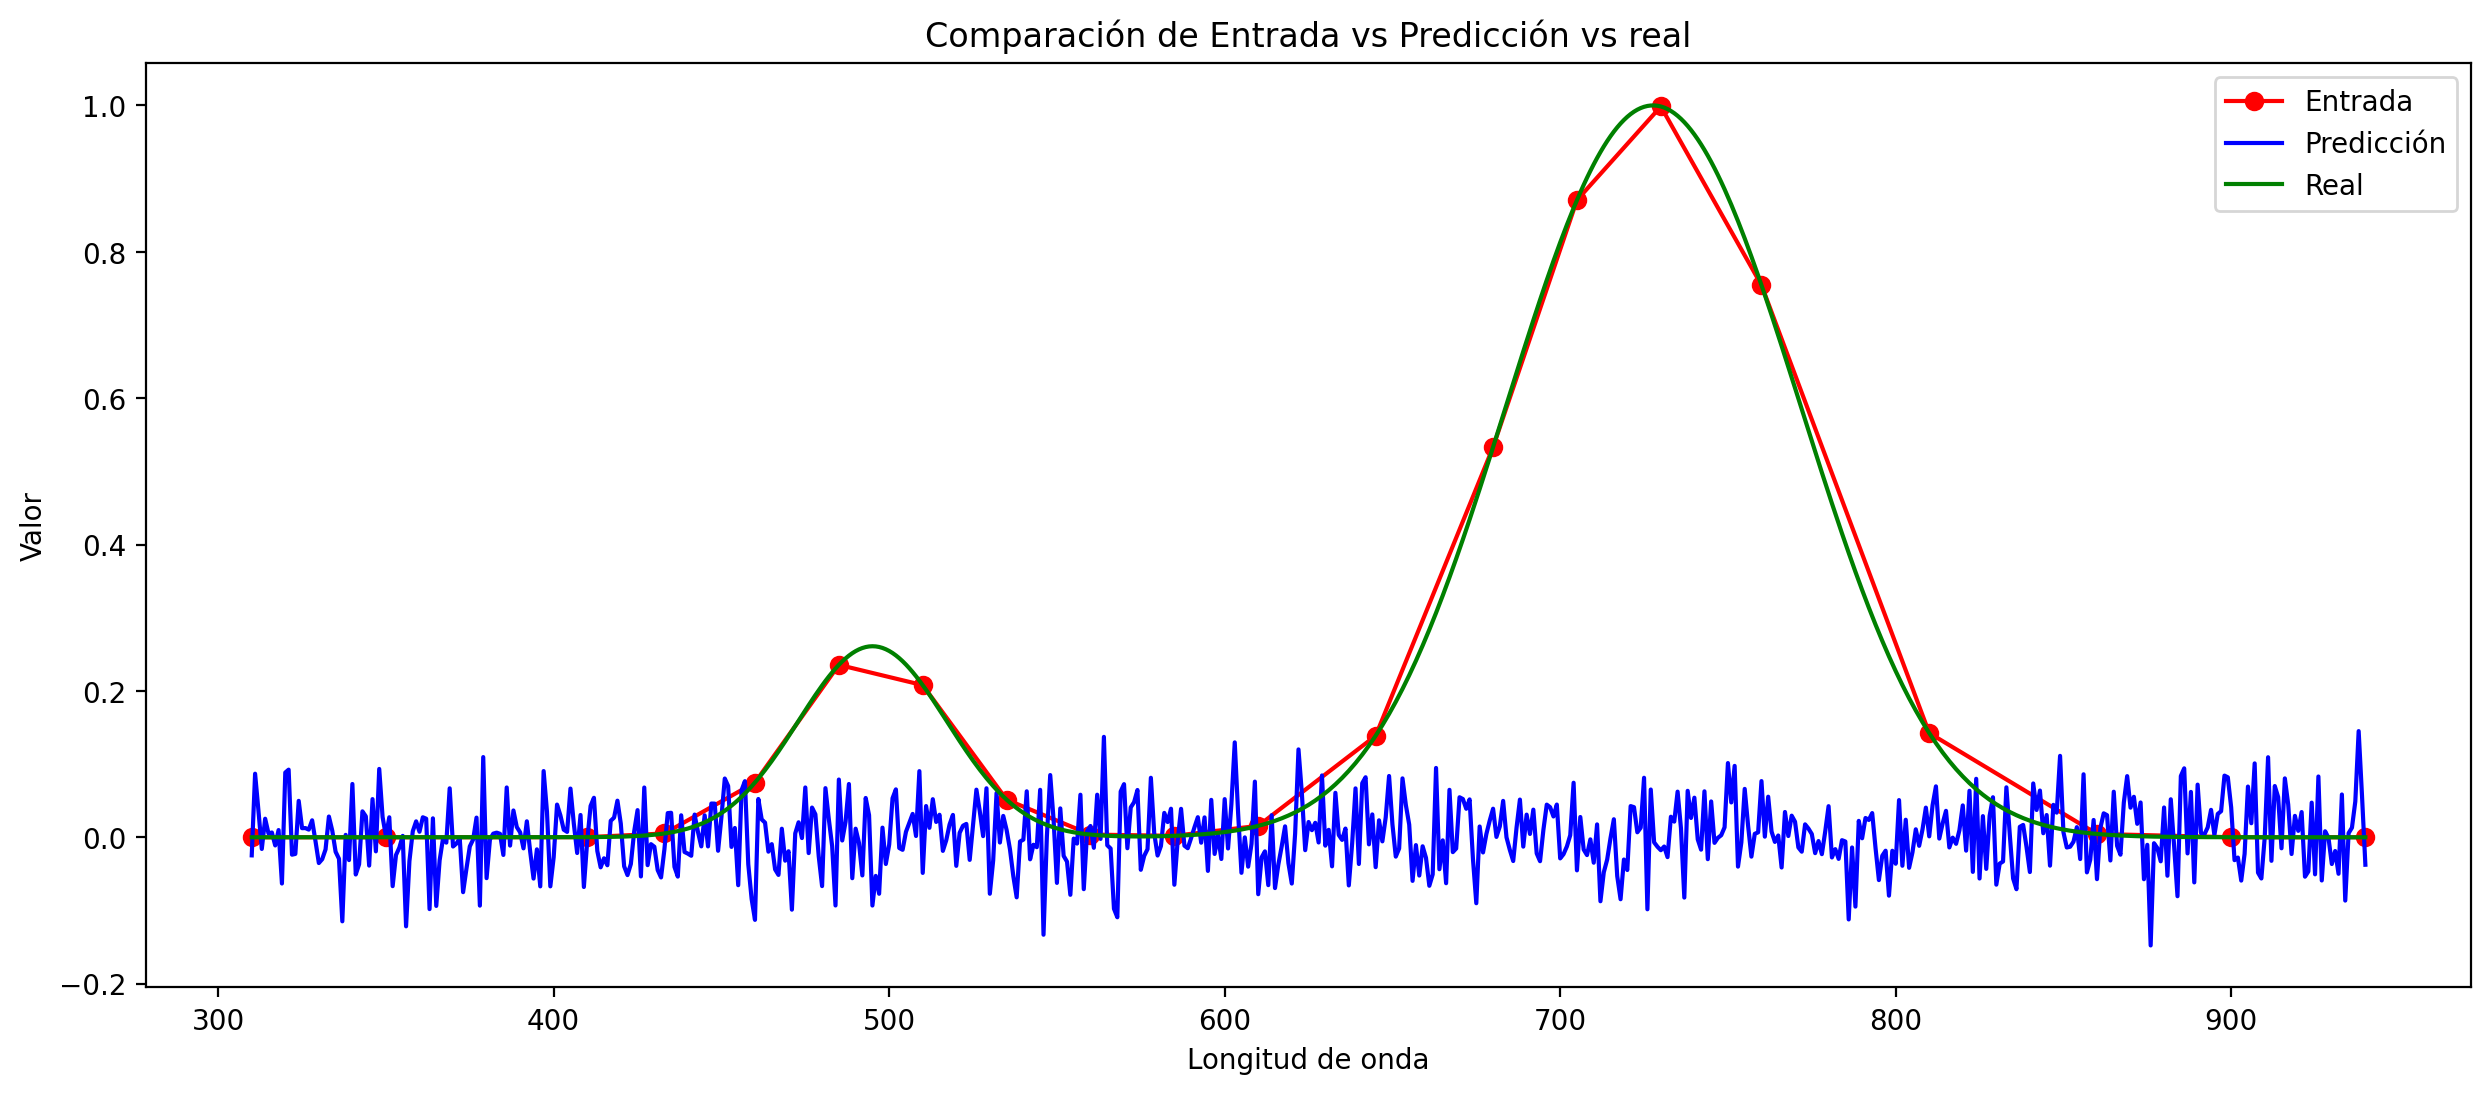

In [18]:
dato = 128
entrada = X_val[dato]
real = y_val[dato,:]

# # Crear una gráfica para comparar los valores reales con las predicciones
plt.figure(figsize=(15, 6))
plt.plot(wavelengths_input, entrada, label='Entrada', color='red', marker='o')
plt.plot(wavelengths_output, predictions[dato], label='Predicción', color='blue')
plt.plot(wavelengths_output, real, label='Real', color='green')
plt.title('Comparación de Entrada vs Predicción vs real')
plt.xlabel('Longitud de onda')
plt.ylabel('Valor')
plt.legend()
plt.show()

C:\Users\VA\AppData\Local\Temp\ipykernel_19612\2915971798.py:7: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


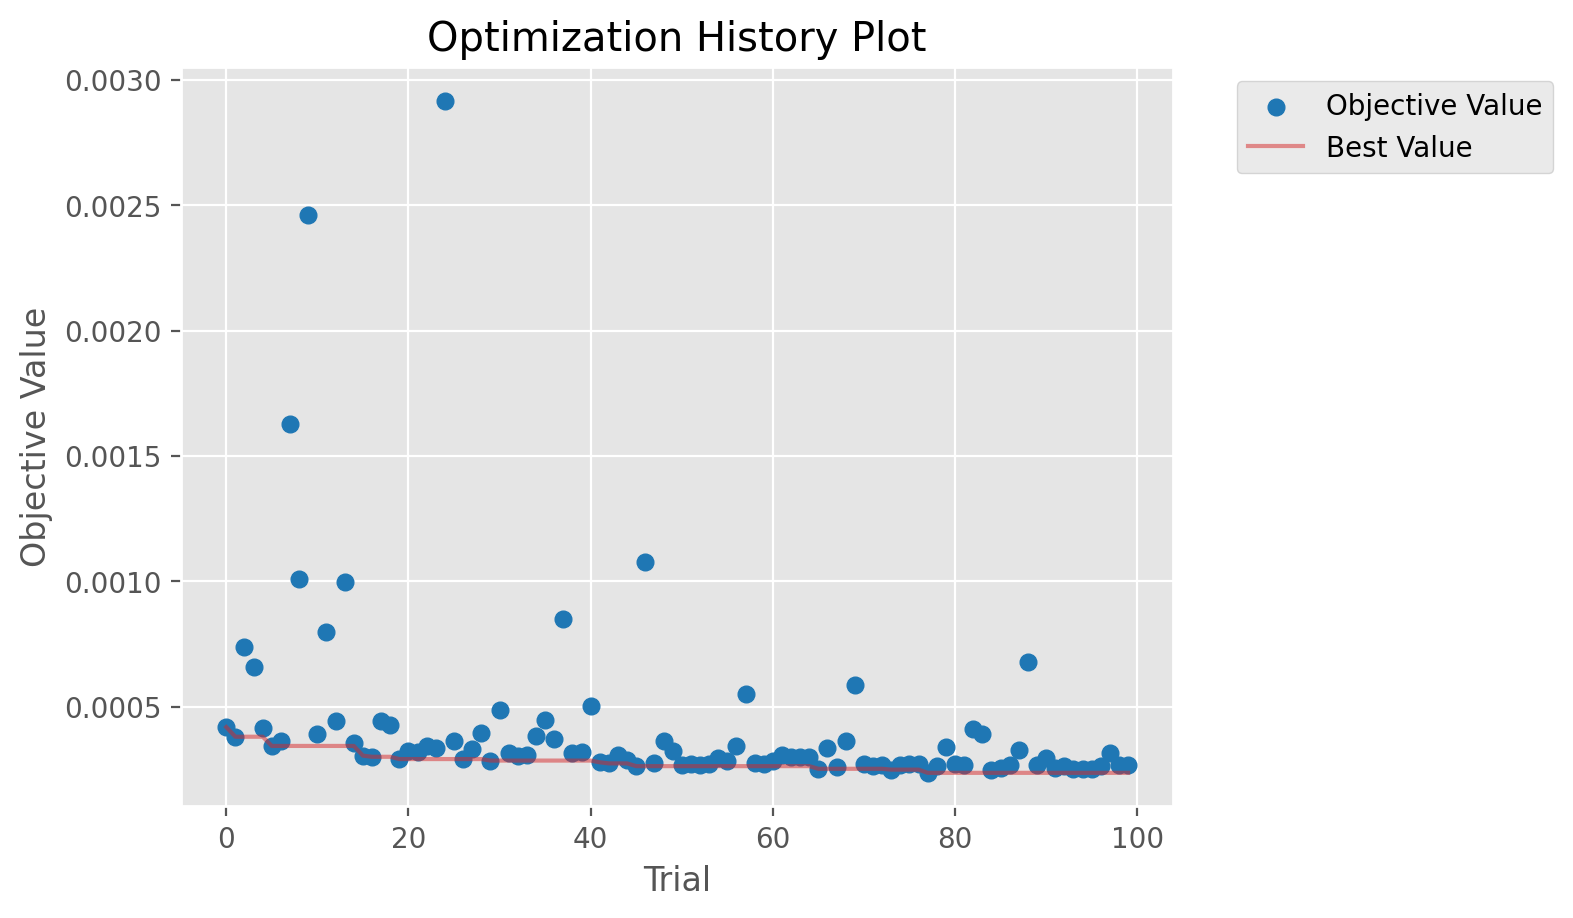

C:\Users\VA\AppData\Local\Temp\ipykernel_19612\2915971798.py:11: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_contour(study, params=['num_filters1', 'kernel_size1', 'initial_LR'])
[W 2024-05-25 01:21:32,060] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


ValueError: Parameter num_filters1 does not exist in your study.

In [8]:
import optuna
import matplotlib.pyplot as plt

# Suponiendo que 'study' es tu objeto de estudio Optuna ya creado y ejecutado

# 1. Historial de optimización
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.show()

# 2. Diagrama de contorno
optuna.visualization.matplotlib.plot_contour(study, params=['num_filters1', 'kernel_size1', 'initial_LR'])
plt.show()

# 3. Importancia de los hiperparámetros
optuna.visualization.matplotlib.plot_param_importances(study)
plt.show()


#### Optimización final

Best trial: {'num_filters1': 150, 'kernel_size1': 7, 'dense_units': 512, 'initial_LR': 0.0018376547234573767, 'decay_steps': 5303, 'decay_rate': 0.8263067995824439}
Best loss: 0.0001704041642369702

Best trial: {'initial_LR': 0.0018543372820540582, 'decay_steps': 2509, 'decay_rate': 0.882128203714003}
Best loss: 0.00015429950144607574

In [ ]:
'''
from tensorflow.keras.callbacks import EarlyStopping

# Configuración de EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitorea la pérdida de validación
    patience=100,         # Número de épocas sin mejora después de las cuales se detiene el entrenamiento
    verbose=1,           # Muestra mensajes cuando se detiene el entrenamiento
    restore_best_weights=True  # Restaura los pesos del modelo desde la época con el mejor valor de la métrica monitorizada
)
'''

In [ ]:
'''
def CNN_1D_final():
    model = Sequential([
        Conv1D(filters=150, kernel_size=7, activation='linear', input_shape=(17, 1)),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(420, activation='relu'),
        Dropout(0.1),
        Dense(511, activation='linear')])
    return model

'''    

In [ ]:
'''
model = CNN_1D_final()

lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001854,
    decay_steps = 2509,
    decay_rate = 0.882128)

model.compile(optimizer=optimizers.Adam(learning_rate=lr_schedule), loss='mean_squared_error')

history_final = model.fit(X_train, y_train, epochs=1000, validation_split = 0.2, callbacks=[early_stopping], verbose = 0, 
                          batch_size = 64)

loss = model.evaluate(X_test, y_test, verbose = 1)
'''

In [20]:
escala = 5
marker = 5
def plot_epochs(history_final):    # li -> limite inferior, ls -> limite superior en y!!!
    plt.figure(figsize=(escala, escala), dpi=100)
    plt.ylim(0, 0.001)
    plt.xlabel("Epochs")
    plt.ylabel("Mean Squared Error")
    plt.plot(history_final.history['loss'],'bo')
    plt.plot(history_final.history['val_loss'],'r')
    
    plt.legend(['Training loss', 'Validation loss'], loc='upper right')
    plt.show()

In [3]:
plot_epochs(history_final)

NameError: name 'history_final' is not defined

In [21]:
# Realizar predicciones

dato = 3
predictions = model.predict(X_train)
entrada = X_train[dato]
real = y_val.iloc[dato,:]

# Crear una gráfica para comparar los valores reales con las predicciones
plt.figure(figsize=(15, 6))
plt.plot(wavelengths_input, entrada, label='Entrada', color='red', marker='o')
plt.plot(wavelengths_output, predictions[dato], label='Predicción', color='blue')
plt.plot(wavelengths_output, real, label='Real', color='green')
plt.title('Comparación de Entrada vs Predicción vs real')
plt.xlabel('Muestras')
plt.ylabel('Valor')
plt.legend()
plt.show()


AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

#### Best

## Post-model